<a href="https://colab.research.google.com/github/naufalihsan/tesseract/blob/master/Text_Predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files

uploaded = files.upload()

Saving train.csv to train.csv


## Read Dataset

In [0]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Unnamed: 0,entity,category
0,0,Mutia Maryati,name
1,1,Padmi Susanti M.Farm,name
2,2,Karen Ayu Nuraini,name
3,3,Bagus Pangestu S.E.,name
4,4,Violet Halimah,name


## Text Cleaning

- remove punctuation
- make lowercase

In [0]:
def primary_name(names):
  names = names.replace('.',' ').split(" ")
  thres = min(3,len(names))
  if len(names[thres-1]) == 1:
    thres -= 1
  return " ".join(names[:thres]).lower()

In [0]:
train = df.copy()
primary_name = train.query('category == "name"')['entity'].apply(lambda x : primary_name(x))

In [0]:
frame = { 'entity': primary_name, 'category': 'name' } 
result = pd.DataFrame(frame) 

In [0]:
from string import digits

def primary_address(address):
  remove_digits = str.maketrans('', '', digits)
  clean = address.translate(remove_digits)
  address = clean.strip().replace('.',' ').replace(',',' ').split(" ")
  if address[0] == 'Jr' or address[0] == 'Jln':
    address[0] = 'jl'
  elif address[0] == 'Dk':
    address[0] = 'dsn'
  elif address[0] == 'Ds':
    address[0] = 'perum'
  elif address[0] == 'Kpg' or address[0] == 'Ki':
    address[0] = 'jl'
  thres = len(address) - 3
  return " ".join(address[:thres])

In [0]:
primary_address = train.query('category == "address"')['entity'].apply(lambda y: primary_address(y))

In [0]:
frame = { 'entity': primary_address, 'category': 'address' } 
result2 = pd.DataFrame(frame)

In [12]:
result3.tail()

,Unnamed: 0,entity,category
1951,484,372497000248300,card
1952,485,5120492984530264,card
1953,486,4251116304283,card
1954,487,5326904234823390,card
1955,488,5515038831113771,card


In [0]:
result = result.append(result2,sort=False, ignore_index=True)
result = result.append(result3,sort=False, ignore_index=True)

In [14]:
display(result.loc[:,'entity':'category'].head())
display(result.loc[:,'entity':'category'].tail())

,entity,category
0,mutia maryati,name
1,padmi susanti,name
2,karen ayu nuraini,name
3,bagus pangestu,name
4,violet halimah,name


,entity,category
1951,372497000248300,card
1952,5120492984530264,card
1953,4251116304283,card
1954,5326904234823390,card
1955,5515038831113771,card


In [15]:
result.query('category == "address"')

,entity,category,Unnamed: 0
489,jl Asia Afrika No Lhokseumawe,address,NaN
490,dsn Ketandan No Kotamobagu,address,NaN
491,Gg Pelajar Pejuang No Magelang,address,NaN
492,perum Dr Junjunan No Depok,address,NaN
493,perum Nanas No Mojokerto,address,NaN
...,...,...,...
973,jl Otto No Ambon,address,NaN
974,perum Basmol Raya No Sungai Penuh,address,NaN
975,Gg Basket No Pekalongan,address,NaN
976,dsn Lada No Sungai Penuh,address,NaN


In [0]:
# from google.colab import files

# result.to_csv('new_train.csv', index = False, header=True)
# files.download('new_train.csv')

## Building model

- build model to classify entity to its category

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df = 0)
X_train_counts = count_vect.fit_transform(result['entity'])

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [0]:
from sklearn.preprocessing import LabelEncoder

# creating mapping from unique label texts to unique integers
# note this can be re-used to encode and decode the labels after as well

encoder = LabelEncoder()
target = encoder.fit_transform(result['category'])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, target, test_size = 0.15, random_state = 21)

In [142]:
datas = ['Naufal Ihsan Pratama',
         'Jakarta  21 01 1989',
         'Jl Patal Senayan Blok A No 15']
X_new_counts = count_vect.transform(datas)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

cheatsheet = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

print(cheatsheet)

{0: 'address', 1: 'card', 2: 'name', 3: 'ttl'}


In [106]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Evaluation model LogisticRegression")
print("Accuracy:", score)

Evaluation model LogisticRegression
Accuracy: 0.9829931972789115


In [143]:
predicted = classifier.predict(X_new_tfidf)

print('Evaluation Test')
for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Naufal Ihsan Pratama => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Patal Senayan Blok A No 15 => Predict type : address


In [108]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [109]:
score = knn.score(X_test, y_test)

print("Evaluation model KNeighborsClassifier")
print("Accuracy :", score)

Evaluation model KNeighborsClassifier
Accuracy : 0.6020408163265306


In [144]:
predicted = knn.predict(X_new_tfidf)

print('Evaluation Test')
for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Naufal Ihsan Pratama => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Patal Senayan Blok A No 15 => Predict type : ttl


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
  "loss":["deviance"],
  "learning_rate": [0.5, 0.75, 1],
  "max_features":["log2","sqrt"],
  "criterion": ["friedman_mse",  "mae"],
}

gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv=2 , n_jobs=-1)
gb.fit(X_train, y_train)

In [0]:
from sklearn.naive_bayes import MultinomialNB

clf = GradientBoostingClassifier(
    n_estimators= 32,
    learning_rate=0.5,
    loss = 'deviance',
    criterion = 'mae',
    max_features = 'log2',
    max_depth = 32,
    random_state=21).fit(X_train, y_train)

In [113]:
score = clf.score(X_test, y_test)

print("Evaluation model GradientBoostingClassifier")
print("Accuracy :", score)

Evaluation model GradientBoostingClassifier
Accuracy : 0.95578231292517


In [145]:
predicted = clf.predict(X_new_tfidf)

print('Evaluation Test')
for doc, category in zip(datas, predicted):
    print('Entity : {} => Predict type : {}'.format(doc, cheatsheet[category]))

Evaluation Test
Entity : Naufal Ihsan Pratama => Predict type : name
Entity : Jakarta  21 01 1989 => Predict type : ttl
Entity : Jl Patal Senayan Blok A No 15 => Predict type : address


Text(0.5, 1.0, 'Confusion Matrix')

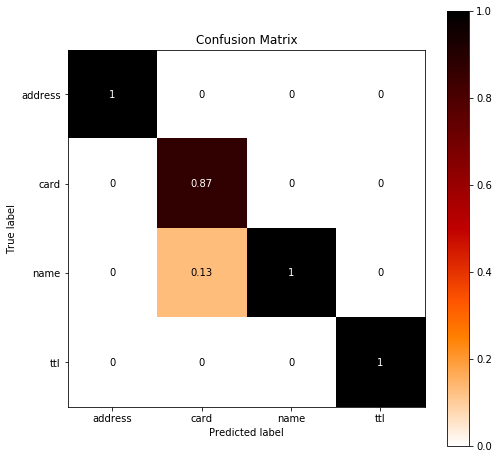

In [115]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib as plt

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels= encoder.classes_,
                                 cmap=plt.cm.gist_heat_r,normalize='pred')
disp.figure_.set_size_inches(8,8)
disp.ax_.set_title('Confusion Matrix')

## Using Keras Model

In [116]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each entity
MAX_SEQUENCE_LENGTH = 5

# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(result['entity'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1740 unique tokens.


In [118]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


X = tokenizer.texts_to_sequences(result['entity'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (1956, 5)


In [119]:
Y = pd.get_dummies(result['category']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1956, 4)


In [120]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 21)
print('Train {}'.format(X_train.shape[0]))
print('Test {}'.format(X_test.shape[0]))

Train 1662
Test 294


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, Y_test),
                    callbacks=[
                      EarlyStopping(monitor='val_loss',
                                    patience=3,
                                    min_delta=0.0001)
                    ])

Train on 1662 samples, validate on 294 samples
Epoch 1/5
1662/1662 [==============================] - 5s 3ms/sample - loss: 1.2546 - accuracy: 0.4158 - val_loss: 0.9406 - val_accuracy: 0.6020
Epoch 2/5
1662/1662 [==============================] - 2s 1ms/sample - loss: 0.7302 - accuracy: 0.7744 - val_loss: 0.4569 - val_accuracy: 0.9694
Epoch 3/5
1662/1662 [==============================] - 2s 1ms/sample - loss: 0.2368 - accuracy: 0.9874 - val_loss: 0.0834 - val_accuracy: 1.0000
Epoch 4/5
1662/1662 [==============================] - 2s 1ms/sample - loss: 0.0425 - accuracy: 0.9970 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 5/5
1662/1662 [==============================] - 2s 1ms/sample - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000


In [125]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

294/294 [==============================] - 0s 114us/sample - loss: 0.0130 - accuracy: 1.0000
Test set
  Loss: 0.013
  Accuracy: 1.000


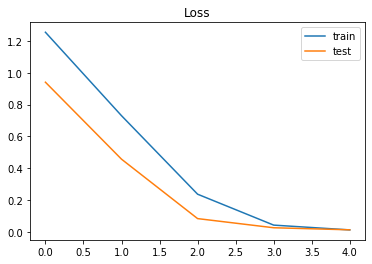

In [126]:
import matplotlib.pyplot as plt 

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

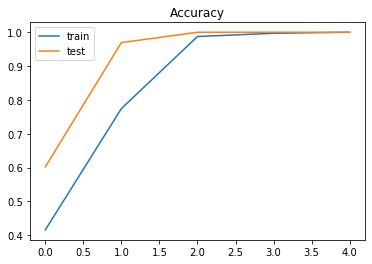

In [128]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [146]:
seq = tokenizer.texts_to_sequences(datas)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['address','card','name','ttl']
idx = 0
for p in pred:
  print(datas[idx],labels[np.argmax(p)])
  idx += 1

Naufal Ihsan Pratama name
Jakarta  21 01 1989 ttl
Jl Patal Senayan Blok A No 15 address
